<a href="https://colab.research.google.com/github/ArturOkeshim/My-training/blob/main/Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import urllib.request
import os
import zipfile
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Model

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
from tensorflow.keras.optimizers import RMSprop
from shutil import copyfile

In [ ]:
data_url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"
data_file_name = "catsdogs.zip"
download_dir = '/tmp/'
urllib.request.urlretrieve(data_url, data_file_name)

('catsdogs.zip', <http.client.HTTPMessage at 0x7c78ef183310>)

In [ ]:
os.listdir()

['.config', 'catsdogs.zip', 'sample_data']

In [ ]:
with  zipfile.ZipFile(data_file_name,'r') as file:
  file.extractall(download_dir)

In [ ]:
print(len(os.listdir('/tmp/PetImages/Cat/')))

12501


In [ ]:
print(len(os.listdir('/tmp/PetImages/Dog/')))

12501


In [ ]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

In [ ]:
os.listdir()

['.config', 'catsdogs.zip', 'sample_data']

In [ ]:
def split_data(source,training,testing,split_size):
  files=list()
  for filename in os.listdir(source):
    file = os.path.join(source,filename)
    if os.path.getsize(file) > 0:
      files.append(filename)
    else:
      print(f"{filename} is empty, ignoring")

  training_length = int(len(files) * split_size)
  testing_length = int(len(files) - training_length)
  shuffled_set = random.sample(files, len(files))
  training_set = shuffled_set[:training_length]
  testing_set = shuffled_set[training_length:]

  for filename in training_set:
    this_file = os.path.join(source,filename)
    destination = os.path.join(training,filename)
    copyfile(this_file,destination)

  for filename in testing_set:
    this_file = os.path.join(source,filename)
    destination = os.path.join(testing,filename)
    copyfile(this_file,destination)



In [ ]:
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

In [ ]:
split_size=0.9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

666.jpg is empty, ignoring
11702.jpg is empty, ignoring


In [ ]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

11250
11250
1250
1250


In [ ]:
training_dir = '/tmp/cats-v-dogs/training/'

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   fill_mode = 'nearest')

In [ ]:
train_generator = train_datagen.flow_from_directory(training_dir,
                                                  batch_size = 32,
                                                  class_mode = 'binary',
                                                  target_size = (150,150))

Found 22499 images belonging to 2 classes.


In [ ]:
validation_dir = "/tmp/cats-v-dogs/testing/"

In [ ]:
validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    batch_size=32,
    class_mode = 'binary',
    target_size = (150,150)
)

Found 2499 images belonging to 2 classes.


In [ ]:
weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [ ]:
weights_file = "inception_v3.h5"

In [ ]:
urllib.request.urlretrieve(weights_url,weights_file)

('inception_v3.h5', <http.client.HTTPMessage at 0x7c78ee0e23d0>)

In [ ]:
pre_trained_model = InceptionV3(input_shape = (150,150,3),
                                 include_top = False,
                                 weights = None)

In [ ]:
pre_trained_model.load_weights(weights_file)

In [ ]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [ ]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output.shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [ ]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dense(1,activation = 'sigmoid')(x)

In [ ]:
model = Model(pre_trained_model.input, x)

In [ ]:
model.compile(optimizer = RMSprop(learning_rate = 0.0001),
              loss = 'binary_crossentropy',
              metrics = ['acc'])

In [ ]:
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    epochs = 20,
    verbose = 1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
608/704 ━━━━━━━━━━━━━━━━━━━━ 21s 227ms/step - acc: 0.8351 - loss: 0.3941

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


704/704 ━━━━━━━━━━━━━━━━━━━━ 184s 243ms/step - acc: 0.8405 - loss: 0.3797 - val_acc: 0.9568 - val_loss: 0.1064
Epoch 2/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 162s 230ms/step - acc: 0.9065 - loss: 0.2211 - val_acc: 0.9600 - val_loss: 0.1083
Epoch 3/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 160s 227ms/step - acc: 0.9140 - loss: 0.2034 - val_acc: 0.9604 - val_loss: 0.1001
Epoch 4/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 159s 226ms/step - acc: 0.9224 - loss: 0.1893 - val_acc: 0.9604 - val_loss: 0.1009
Epoch 5/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 166s 235ms/step - acc: 0.9195 - loss: 0.1942 - val_acc: 0.9664 - val_loss: 0.0921
Epoch 6/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 180s 256ms/step - acc: 0.9274 - loss: 0.1817 - val_acc: 0.9640 - val_loss: 0.0926
Epoch 7/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 169s 240ms/step - acc: 0.9262 - loss: 0.1769 - val_acc: 0.9660 - val_loss: 0.0950
Epoch 8/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 169s 240ms/step - acc: 0.9325 - loss: 0.1671 - val_acc: 0.9656 - val_loss: 0.0931
Epoch 9/20
704/704 ━━━━━━━━━━━━━━━━

In [ ]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
epochs = range(len(acc))

<Figure size 640x480 with 0 Axes>

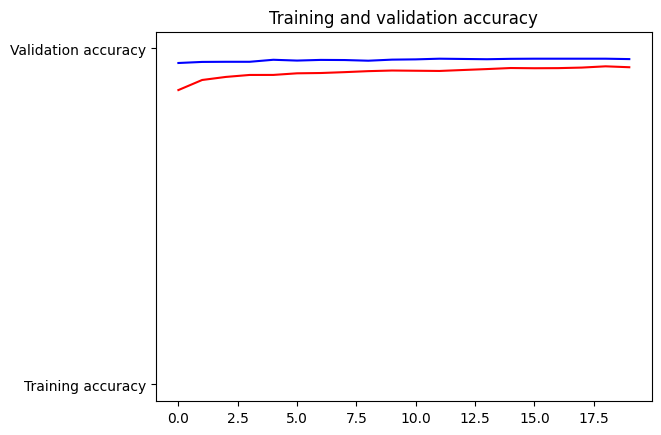

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(epochs, acc, 'r', "Training accuracy")
plt.plot(epochs, val_acc, 'b', 'Validation accuracy')
plt.title("Training and validation accuracy")
plt.figure()